In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import json
import numpy as np


data_file_name = 'data.json'
data_file_path = f'/content/drive/My Drive/Project Data/JSON Data/{data_file_name}'

# Open the JSON file
with open(data_file_path, 'r') as file:
    # Load the JSON data
    loaded_json_data = json.load(file)

# create numpy array 'data_array'
data_array = np.array(loaded_json_data['x'])
# convert array values to float
data_array = data_array.astype(float)

In [3]:
from scipy.signal import butter, filtfilt


# Define the filter parameters
lower_freq_limit = 1
higher_freq_limit = 50
sampling_rate = 250  # Assuming a sampling rate of 250Hz

# Calculate the Nyquist frequency
nyquist_freq = 0.5 * sampling_rate

# Normalize the cutoff frequencies
normalized_lower_freq_limit = lower_freq_limit / nyquist_freq
normalized_higher_freq_limit = higher_freq_limit / nyquist_freq

# Determines the sharpness of the filter's cutoff
# (How aggressively the filter removes frequencies outside the desired passband)
filter_order = 2

# Compute the Butterworth filter coefficients
filter_coeff_1, filter_coeff_2 = butter(
    filter_order, [normalized_lower_freq_limit, normalized_higher_freq_limit],
    btype='band')

# Apply the filter to each data sample in data_array
filtered_data = np.zeros_like(data_array)
for row_index in range(data_array.shape[0]):
    for col_index in range(data_array.shape[1]):
        filtered_data[row_index, col_index, :] = filtfilt(
            filter_coeff_1, filter_coeff_2, data_array[row_index, col_index, :])

In [4]:
from sklearn.decomposition import PCA


flattened_filtered_data = filtered_data.reshape(
    (filtered_data.shape[0], -1))
flattened_filtered_data = np.nan_to_num(flattened_filtered_data, nan=0)

pca = PCA(n_components=120)
pca_transformed_filtered_data = pca.fit_transform(flattened_filtered_data)

In [5]:
output_values = loaded_json_data['y']
output_values = [x - 1 for x in output_values]

In [6]:
mean_of_data = np.mean(filtered_data, axis=0)
std_of_data = np.std(filtered_data, axis=0)

# Normalize the data by subtracting the mean and
# dividing by the standard deviation
normalized_data = (filtered_data - mean_of_data) / std_of_data

np_list = pca_transformed_filtered_data
np_list = np.nan_to_num(np_list, nan=0)

flattened_data = np_list.reshape(np_list.shape[0], -1)

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, train_test_split


lda = LinearDiscriminantAnalysis()
accuracies = cross_val_score(lda, flattened_data, output_values, cv=15)
accuracy = mean_accuracy = accuracies.mean() * 100

print(f"Accuracy: {accuracy:.4f}")

Accuracy: 41.7368



 Classification report: 

               precision    recall  f1-score   support

           0       0.38      0.43      0.40        14
           1       0.38      0.47      0.42        17
           2       0.67      0.67      0.67        12
           3       0.78      0.47      0.58        15

    accuracy                           0.50        58
   macro avg       0.55      0.51      0.52        58
weighted avg       0.54      0.50      0.51        58


 Confusion matrix: 

 [[6 6 1 1]
 [7 8 2 0]
 [1 2 8 1]
 [2 5 1 7]]


<Axes: >

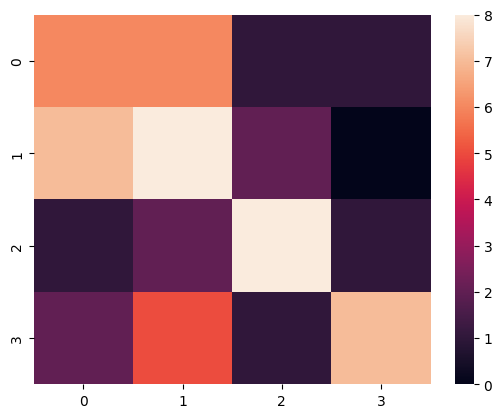

In [8]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


X_train, X_test, y_train, y_test = train_test_split(
    flattened_data, output_values, test_size=0.2, random_state=42)

lda.fit(X_train, y_train)

# Evaluate the model
y_pred = lda.predict(X_test)

print('\n Classification report: \n\n',
      classification_report(
          y_test,
          y_pred
      ))

# Create the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Analyze the confusion matrix
print('\n Confusion matrix: \n\n', confusion_mat)

sns.heatmap(confusion_mat)